The basic idea of the paper is to find way to accumulate the video of the gesture in a single image, and then use (and train) the recognizer on that single frame.

Their approach can be seen as an eulerian description of a fluid flow. Where they analyse a give control volume to detect the gestures. My approach uses, at least so far, a lagrangian description for the gesture recognition.

Can I generate a single frame that somehow aggregate all the information of a video in a single frame to do the gesture recognition?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import mediapipe as mp
from datetime import datetime
import cv2
import time
from gesture.base import Gesture, hand_frame_of_reference, angle_hand, mean_absolute_error, cosine_similarity
import pandas as pd

In [2]:
one_data_test = pd.read_csv(
    "./gesture_data/ONE_YT_2_Transcription_Right_Hand.csv",
    parse_dates=True,
)

In [3]:
def to_hand_frame(coordinates: np.array, norm: bool = True) -> np.array:
    """Rotate and translates the coordinates to the hand frame of reference.

    Parameters
    ----------
    coordinates: np.array
        A 2D array containing the coordinates of the points to rotate.
    norm: bool
        A bool indicating if the coordinates should be normalized.

    Returns
    -------
    coordinates_hand_frame: np.array
        A 2D array containing the coordinates of the points in the hand frame of reference.
    """
    coordinates = coordinates.astype(float)
    # The hand frame of reference is obtained by the hand_frame_of_reference function.
    hand_frame = hand_frame_of_reference(coordinates)
    # The rotation matrix is the transpose of the hand frame of reference.
    rotation_matrix = hand_frame.T
    # The coordinates in the hand frame of reference are obtained by multiplying the rotation matrix by the coordinates.
    coordinates_hand_frame = np.zeros_like(coordinates)
    for i in range(coordinates.shape[0]):
        coordinates_hand_frame[i] = np.dot(
            rotation_matrix, coordinates[i] - coordinates[0]
        )
    # for i in range(coordinates.shape[0]):
    #     coordinates_hand_frame[i] = coordinates[i] - coordinates[0]
    if norm:
        # The coordinates are normalized by dividing them by the maximum absolute value of the coordinates.
        coordinates_hand_frame = coordinates_hand_frame / np.abs(
            coordinates_hand_frame
        ).max(axis=0)
    return coordinates_hand_frame

In [4]:
def get_data_in_time(one_data_test, time = None):
    one_data_test = one_data_test.copy()
    one_data_test["time"] = pd.to_datetime(one_data_test["time"], format="%H:%M:%S.%f")
    one_data_test["time"] = one_data_test["time"] - one_data_test["time"][0]
    one_data_test["time"] = one_data_test["time"].dt.total_seconds()
    # Filter to get only the data of the one signal
    if time is not None:
        one_data_test = one_data_test[one_data_test["time"] >= time[0]]
        one_data_test = one_data_test[one_data_test["time"] <= time[1]]
        one_data_test["time"] = one_data_test["time"] - one_data_test["time"].iloc[0]
    # And transform it to the same shape as the one_base
    one_test_ni = []
    for index in range(21):
        index_data = one_data_test[one_data_test["index"] == index]
        index_data = index_data.sort_values(by="time")
        one_test_ni.append(
            [
                index_data["x"].values,
                index_data["y"].values,
                index_data["z"].values,
                index_data["time"].values,
            ]
        )
    one_test_ni = np.array(one_test_ni)
    return one_test_ni

In [5]:
limb_connections = {
    "thumb": np.array([0, 1, 2, 3, 4]),
    "index": np.array([0, 5, 6, 7, 8]),
    "middle": np.array([0, 9, 10, 11, 12]),
    "ring": np.array([0, 13, 14, 15, 16]),
    "pinky": np.array([0, 17, 18, 19, 20]),
    "palm": np.array([2, 5, 9, 13, 17]),
    # "sequential": np.arange(0, 21),
}
def video_of_hand(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.view_init(-90, 0, 0)
    xdata, ydata, zdata = [], [], []
    (ln1,) = ax.plot([], [], [], "r", lw=5)
    (ln2,) = ax.plot([], [], [], "r", lw=5)
    (ln3,) = ax.plot([], [], [], "r", lw=5)
    (ln4,) = ax.plot([], [], [], "r", lw=5)
    (ln5,) = ax.plot([], [], [], "r", lw=5)
    (ln6,) = ax.plot([], [], [], "r", lw=5)
    (ln_ref1,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref2,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref3,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref4,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref5,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref6,) = ax.plot([], [], [], "b", lw=5)
    L = plt.legend(loc=1)  # Define legend objects

    def init():
        ax.set_xlim(data[:, 0, :].min() - 0.1, data[:, 0, :].max() + 0.1)
        ax.set_ylim(data[:, 1, :].min() - 0.1, data[:, 1, :].max() + 0.1)
        ax.set_zlim(data[:, 2, :].min() - 0.1, data[:, 2, :].max() + 0.1)
        return (
            ln1,
            ln2,
            ln3,
            ln4,
            ln5,
            ln6,
            ln_ref1,
            ln_ref2,
            ln_ref3,
            ln_ref4,
            ln_ref5,
            ln_ref6,
        )

    def update(i):
        # get the data of each limb
        ln1_data = data[limb_connections["thumb"], :-1, i]
        ln2_data = data[limb_connections["index"], :-1, i]
        ln3_data = data[limb_connections["middle"], :-1, i]
        ln4_data = data[limb_connections["ring"], :-1, i]
        ln5_data = data[limb_connections["pinky"], :-1, i]
        ln6_data = data[limb_connections["palm"], :-1, i]
        # # get the ref data of each limb
        # ln_ref1_data = static_base_points_in_hand_frame[limb_connections["thumb"], :]
        # ln_ref2_data = static_base_points_in_hand_frame[limb_connections["index"], :]
        # ln_ref3_data = static_base_points_in_hand_frame[limb_connections["middle"], :]
        # ln_ref4_data = static_base_points_in_hand_frame[limb_connections["ring"], :]
        # ln_ref5_data = static_base_points_in_hand_frame[limb_connections["pinky"], :]
        # ln_ref6_data = static_base_points_in_hand_frame[limb_connections["palm"], :]
        # Update the data of each limb
        ln1.set_data(ln1_data[:, 0], ln1_data[:, 1])
        ln1.set_3d_properties(ln1_data[:, 2])
        ln2.set_data(ln2_data[:, 0], ln2_data[:, 1])
        ln2.set_3d_properties(ln2_data[:, 2])
        ln3.set_data(ln3_data[:, 0], ln3_data[:, 1])
        ln3.set_3d_properties(ln3_data[:, 2])
        ln4.set_data(ln4_data[:, 0], ln4_data[:, 1])
        ln4.set_3d_properties(ln4_data[:, 2])
        ln5.set_data(ln5_data[:, 0], ln5_data[:, 1])
        ln5.set_3d_properties(ln5_data[:, 2])
        ln6.set_data(ln6_data[:, 0], ln6_data[:, 1])
        ln6.set_3d_properties(ln6_data[:, 2])
        # # Update the ref data of each limb
        # ln_ref1.set_data(ln_ref1_data[:, 0], ln_ref1_data[:, 1])
        # ln_ref1.set_3d_properties(ln_ref1_data[:, 2])
        # ln_ref2.set_data(ln_ref2_data[:, 0], ln_ref2_data[:, 1])
        # ln_ref2.set_3d_properties(ln_ref2_data[:, 2])
        # ln_ref3.set_data(ln_ref3_data[:, 0], ln_ref3_data[:, 1])
        # ln_ref3.set_3d_properties(ln_ref3_data[:, 2])
        # ln_ref4.set_data(ln_ref4_data[:, 0], ln_ref4_data[:, 1])
        # ln_ref4.set_3d_properties(ln_ref4_data[:, 2])
        # ln_ref5.set_data(ln_ref5_data[:, 0], ln_ref5_data[:, 1])
        # ln_ref5.set_3d_properties(ln_ref5_data[:, 2])
        # ln_ref6.set_data(ln_ref6_data[:, 0], ln_ref6_data[:, 1])
        # ln_ref6.set_3d_properties(ln_ref6_data[:, 2])

        return (
            ln1,
            ln2,
            ln3,
            ln4,
            ln5,
            ln6,
            ln_ref1,
            ln_ref2,
            ln_ref3,
            ln_ref4,
            ln_ref5,
            ln_ref6,
        )

    ani = FuncAnimation(
        fig,
        update,
        frames=list(range(data.shape[2])),
        init_func=init,
        blit=True,
        interval=100,
    )

    return HTML(ani.to_html5_video())


# for i in range(one_base.shape[2]):
#     one_base[:, :-1, i] = to_hand_frame(one_base[:, :-1, i])


/tmp/ipykernel_56424/53469682.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


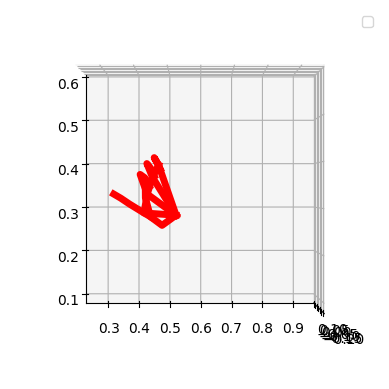

In [6]:
one_base = get_data_in_time(one_data_test, [4, 6.3])
video_of_hand(one_base)

In [7]:
def plot_hand(data,view = (-90,0,0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    for limb in limb_connections.values():
        ax.plot(
            data[limb, 0],
            data[limb, 1],
            data[limb, 2],
            color="blue",
            marker=".",
        )
    ax.view_init(view[0], view[1], view[2])
    plt.show()

Now that we have the code that loads the video, let's calculate sum of differences of the video

In [8]:
one_base.shape

(21, 4, 35)

In [129]:
def sum_of_diferences(hand_data, norm = True):
    sum_of_diferences = np.zeros((hand_data.shape[0],3))
    for frame in range(hand_data.shape[2]):
        if norm:
            hand_data_hand_frame = to_hand_frame(hand_data[:, :3, frame])
            hand_data_hand_framem1 = to_hand_frame(hand_data[:, :3, frame-1])
        else:
            hand_data_hand_frame = hand_data[:, :3, frame]
            hand_data_hand_framem1 = hand_data[:, :3, frame-1]
        if frame == 0:
            difference = hand_data_hand_frame
        if frame > 0:
            difference =  hand_data_hand_frame
        # Here could (and possibly should) normalize the difference
        sum_of_diferences += difference
        # sum_of_diferences = to_hand_frame(sum_of_diferences, norm = False)   
    # Can't we normalize the sum of differences?
    # sum_of_diferences = np.abs(sum_of_diferences) / np.abs(sum_of_diferences).max(axis=0)
    # sum_of_diferences = to_hand_frame(sum_of_diferences, norm = True)
    return sum_of_diferences

In [130]:
one_video_aggregated = sum_of_diferences(one_base)
one_video_aggregated.shape


(21, 3)

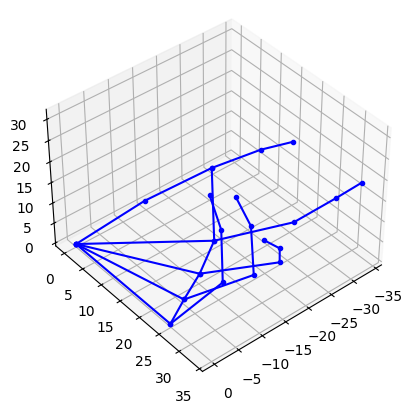

In [131]:
# %matplotlib qt 
# %matplotlib inline
plot_hand(one_video_aggregated, view = (40,50,0))

In [132]:
base = [
    "ELEVEN",
    "TWELVE",
    "THIRTEEN",
    "FOURTEEN",
    "FIFTEEN",
    "SIXTEEN",
    "SEVENTEEN",
    "EIGHTEEN",
    "NINETEEN",
    "TWENTY",
    "J",
    "Z",
]
base_data = [
    get_data_in_time(
        pd.read_csv(
            f"./gesture_data/{test}_Transcription_Right_Hand.csv", parse_dates=True
        ),
    )
    for test in base
]
tests = [
    "ELEVEN_1",
    "TWELVE_1",
    "THIRTEEN_1",
    "FOURTEEN_1",
    "FIFTEEN_1",
    "SIXTEEN_1",
    "SEVENTEEN_1",
    "EIGHTEEN_1",
    "NINETEEN_1",
    "TWENTY_1",
    "J_1",
    "Z_1",
]
test_data = [
    get_data_in_time(
        pd.read_csv(
            f"./gesture_data/{test}_Transcription_Right_Hand.csv",
            parse_dates=True,
        ),
    )
    for test in tests
]

In [133]:
for i in range(len(base_data)):
    base_data[i] = sum_of_diferences(base_data[i])
for i in range(len(test_data)):
    test_data[i] = sum_of_diferences(test_data[i])

Let's compare the hands video using this approach

In [134]:
def compare_hand(base_points: np.array, incoming_points: np.array) -> float:
        """
        Compare the base points of the hand with the incoming points of the hand.

        Parameters
        ----------
        base_points: np.array
            The base points of the hand.
        incoming_points: np.array
            The incoming points of the hand.

        Returns
        -------
        error: float
            The error between the base points and the incoming points.
        """
        # Load the base points in the hand frame of reference.
        base_points_in_hand_frame: np.array = to_hand_frame(base_points)
        # Load the incoming points in the hand frame of reference.
        incoming_points_in_hand_frame: np.array = to_hand_frame(incoming_points)
        # # Mean squared error of distance of points.
        # error_points_distance = mean_squared_error(
        #     base_points_in_hand_frame,  # [:, :2],
        #     incoming_points_in_hand_frame,  # [:, :2]
        # )
        # # Get the angle indicating of the base and incoming points.
        angle_hand_inc = angle_hand(incoming_points)
        # print(angle_hand_inc)
        angle_hand_base = angle_hand(base_points)
        # # Mean squared error of the angle of the hand.
        error_rotation = mean_absolute_error(angle_hand_base, angle_hand_inc) / (
            8 * np.pi
        )
        # print(error_rotation)
        # # 8 * np.pi is the best tested scaling factor

        error_points_distance = cosine_similarity(
            base_points_in_hand_frame,
            incoming_points_in_hand_frame,
            flatten=True,
        )
        # error = 1-cosine_similarity(
        #     base_points_zzero.flatten(), incoming_points_zzero.flatten()
        # )
        error = error_points_distance + error_rotation
        return error

In [135]:
corrects = 0
for j in range(len(base_data)):
        dtw_scores = []
        for i, test in enumerate(test_data):
            dtw_scores.append(compare_hand(base_data[j], test))
            print(f"Comparing {base[j]} with {tests[i]}, Static acum score = {dtw_scores[-1]:.4f}")
        min_dtw_index = np.argmin(dtw_scores)
        if j == min_dtw_index:
            corrects += 1
        print(f"Identifyed {tests[min_dtw_index]} as {base[j]}")
        print("\n")
print(f"Corrects: {corrects}/{len(base_data)}")

Comparing ELEVEN with ELEVEN_1, Static acum score = 0.0363
Comparing ELEVEN with TWELVE_1, Static acum score = 0.0660
Comparing ELEVEN with THIRTEEN_1, Static acum score = 0.1470
Comparing ELEVEN with FOURTEEN_1, Static acum score = 0.0763
Comparing ELEVEN with FIFTEEN_1, Static acum score = 0.1338
Comparing ELEVEN with SIXTEEN_1, Static acum score = 0.0443
Comparing ELEVEN with SEVENTEEN_1, Static acum score = 0.0471
Comparing ELEVEN with EIGHTEEN_1, Static acum score = 0.1090
Comparing ELEVEN with NINETEEN_1, Static acum score = 0.0925
Comparing ELEVEN with TWENTY_1, Static acum score = 0.1688
Comparing ELEVEN with J_1, Static acum score = 0.4164
Comparing ELEVEN with Z_1, Static acum score = 0.3295
Identifyed ELEVEN_1 as ELEVEN


Comparing TWELVE with ELEVEN_1, Static acum score = 0.0304
Comparing TWELVE with TWELVE_1, Static acum score = 0.0229
Comparing TWELVE with THIRTEEN_1, Static acum score = 0.1034
Comparing TWELVE with FOURTEEN_1, Static acum score = 0.0260
Comparing TWELVE 